<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python -V

Python 3.7.10


In [2]:
!pip install -U pip
!pip install -U japanize_matplotlib

     |████████████████████████████████| 1.6MB 7.0MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 4.1 MB 5.0 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120274 sha256=9d416c458537c53c4e7cf3e14bfb0801fa3796b5901ee3902c9bcb6a452b6caa
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib


In [3]:
import requests
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import datetime
import re
from pytz import timezone
from tqdm.notebook import tqdm

%matplotlib inline

### COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19/blob/development/FORKED_SITES.md

In [4]:
urls = {
    'tokyo': 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json',
#     'saitama': 'https://raw.githubusercontent.com/codefortoda/covid19-saitama/development/data/data.json',
    'aichi': 'https://raw.githubusercontent.com/code4nagoya/covid19/development/data/data.json',
#     'osaka': 'https://raw.githubusercontent.com/codeforosaka/covid19/development/data/data.json',
    'hyogo': 'https://raw.githubusercontent.com/stop-covid19-hyogo/covid19/development/data/patients_summary.json',
    'fukui': 'https://raw.githubusercontent.com/nomunomu0504/covid19/nomu_development/data/patients_summary.json',
    'tottori': 'https://raw.githubusercontent.com/tottori-covid19/covid19/master/data/data.json',
    'shimane': 'https://raw.githubusercontent.com/TaigaMikami/shimane-covid19/shimane/data/patients_summary.json',
    'okinawa': 'https://raw.githubusercontent.com/Code-for-OKINAWA/covid19/development/data/data.json',
    'fukuoka': 'https://raw.githubusercontent.com/Code-for-Fukuoka/covid19-fukuoka/development/data/data.json',
    'hokkaido': 'https://stopcovid19.hokkaido.dev/api/patients_summary.json',
#     'kanagawa': 'https://www.pref.kanagawa.jp/osirase/1369/data/data.json',
    ##'chiba': 'https://raw.githubusercontent.com/civictechzenchiba/covid19-chiba/development/data/data.json',
    #'hiroshima': 'https://raw.githubusercontent.com/tatsuya1970/covid19/development/data/data.json',
    'fukushima': 'https://cdn2.dott.dev/data.json',
#     'chiba': 'https://covid19chiba.s3-ap-northeast-1.amazonaws.com/DataPub.json',
    'shizuokashi': 'https://db7rdtcq3byow.cloudfront.net/data.json',
    'hamamatsushi': 'https://raw.githubusercontent.com/code-for-hamamatsu/covid19/dev-hamamatsu/data/hamamatsu/data.json',
    'shiga': 'https://shiga-pref-org.github.io/covid19-data/data.json',
}

In [5]:
def get_json_data(pref: str, url: str) -> dict:
    response = requests.get(url)
    json_data = json.loads(response.text)
    
    # json文字列をdictへ
    if pref == 'shimane':
        return json_data['patients_summary']
    if pref == 'hokkaido':
        return {'data': [{'日付': j['日付'], '小計': j['日陽性数']} for j in json_data['data']]}
    if pref == 'kanagawa':
        print(json_data['patient'])
#     print(json_data['patients_summary']['data'])
    return json_data

In [6]:
#res = get_json_data('https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json')
#print(type(res))
#res

In [7]:
def datetime_to_date(datestr: str) -> datetime:
    return datetime.datetime.strptime(re.sub(r'T.*$', '', datestr), '%Y-%m-%d')

In [8]:
def utc_datestr_to_jst_date(datestr: str) -> datetime:
   return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  #return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [9]:
#utc_datestr_to_jst_date('2020-08-12T12:34:56.789Z')

In [10]:
def get_patients_count(json_data: dict, file_name: str) -> list:
    if file_name == 'data.json':
        return [data['小計'] for data in json_data['patients_summary']['data']]
    return [data['小計'] for data in json_data['data']]

In [11]:
def get_df_index(json_data: dict, file_name: str):
    if file_name == 'data.json':
        return [datetime_to_date(d['日付']) for d in json_data['patients_summary']['data']]
#         return pd.date_range(
#             start=datetime_to_date(json_data['patients_summary']['data'][0]['日付']),
#             end=datetime_to_date(json_data['patients_summary']['data'][-1]['日付']),
#             freq='D')
    return [datetime_to_date(d['日付']) for d in json_data['data']]
#     return pd.date_range(
#             start=datetime_to_date(json_data['data'][0]['日付']),
#             end=datetime_to_date(json_data['data'][-1]['日付']),
#             freq='D')

In [12]:
def get_data(pref: str, url: str):
    json_data = get_json_data(pref, url)
#     print(json_data)
    file_name = url.split('/')[-1]

    # 日毎の数
    patients_count = get_patients_count(json_data, file_name)
    # dataframe index
    df_index = get_df_index(json_data, file_name)

    # データフレームにセット（インデックスに日付をセット）
    df = pd.DataFrame({'patients_count': patients_count}, index=df_index)
    # 7日間移動平均・合計カラムを追加
    try:
        df['7d_mov_ave'] = df['patients_count'].rolling('7D').mean()
        df['7d_mov_sum'] = df['patients_count'].rolling('7D').sum()
    except Exception as e:
        print(e)
        df['7d_mov_ave'] = np.zeros(len(df['patients_count']))
        df['7d_mov_sum'] = np.zeros(len(df['patients_count']))
        
    return df

In [13]:
# url = urls['tottori']
# print(url)
# res = get_data(url)
# print(type(res))
# print(res.tail(15))

In [14]:
for k, v in tqdm(urls.items()):
    print(k, v)
    res = get_data(k, v)
    #res = get_data('https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json')
    #res = get_data('https://raw.githubusercontent.com/stop-covid19-hyogo/covid19/development/data/patients_summary.json')
    print(type(res))
    print(res.tail(15))
    print('-----')

tokyo https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json
<class 'pandas.core.frame.DataFrame'>
            patients_count  7d_mov_ave  7d_mov_sum
2021-06-19             388  377.714286      2644.0
2021-06-20             376  388.000000      2716.0
2021-06-21             236  391.857143      2743.0
2021-06-22             435  405.857143      2841.0
2021-06-23             619  422.714286      2959.0
2021-06-24             570  439.571429      3077.0
2021-06-25             562  455.142857      3186.0
2021-06-26             534  476.000000      3332.0
2021-06-27             386  477.428571      3342.0
2021-06-28             317  489.000000      3423.0
2021-06-29             476  494.857143      3464.0
2021-06-30             714  508.428571      3559.0
2021-07-01             673  523.142857      3662.0
2021-07-02             660  537.142857      3760.0
2021-07-03             716  563.142857      3942.0
-----
aichi https://raw.githubusercontent.com/co

In [15]:
def week_num(d: datetime) -> str:
    return f'\'{d.strftime("%y")}w{d.strftime("%V")}'

In [16]:
def week_num_list(l: list) -> list:
    return [week_num(d) for d in l]

In [17]:
def week_day(d: datetime) -> str:
    return d.strftime('%a')

In [18]:
def week_day_list(l: list) -> list:
    return [week_day(d) for d in l]

In [19]:
# res = pd.DataFrame({
#     'week_num': week_num_list([(datetime.datetime(2020,1,1) + datetime.timedelta(i)) for i in range(370)]),
#     'week_day': week_day_list([(datetime.datetime(2020,1,1) + datetime.timedelta(i)) for i in range(370)])
# })
# print(type(res))
# res

In [20]:
def get_df(pref: str, url: str):
    df = get_data(pref, url)
    # 日付カラムを追加
    df['datetime'] = df.index
    # 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
    df['week_num'] = week_num_list(df.index)
    # 曜日の列をセット
    df['week_day'] = week_day_list(df.index)
    return df

In [21]:
#res = get_df('https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json')
#print(type(res))
#res

In [22]:
def agg_df(df):
    # 週毎に集計
    groupby_week_num = df.groupby('week_num')
    # 集計結果から平均と合計を取得しデータフレームにセット
    return pd.DataFrame({
        'week_num': df['week_num'].unique(),
        'week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
        'week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
    }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])

In [23]:
# res = agg_df(get_df('https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'))
# print(type(res))
# res

In [24]:
dfs = {}
weekly_agg_dfs = {}
for k, v in tqdm(urls.items()):
    df = get_df(k, v)
    weekly_agg_df = agg_df(df)
    # 集計カラムを追加
    df = pd.concat([
        df, weekly_agg_df.loc[:, ['week_mean', 'week_sum']]
    ], axis=1)
    dfs[k] = df
#     weekly_agg_dfs[item[0]] = weekly_agg_df

#print(min([len(v) for k, v in dfs.items()]))
#print(weekly_agg_dfs)

In [25]:
pd.DataFrame({k: dfs[k]['patients_count'] for k in dfs.keys()}, index=dfs['tokyo'].index).tail(15)

,tokyo,aichi,hyogo,fukui,tottori,shimane,okinawa,fukuoka,hokkaido,fukushima,shizuokashi,hamamatsushi,shiga
2021-06-19,388,NaN,18.0,8.0,NaN,NaN,97.0,NaN,NaN,11.0,7.0,NaN,NaN
2021-06-20,376,NaN,19.0,22.0,NaN,NaN,61.0,NaN,NaN,10.0,6.0,NaN,NaN
2021-06-21,236,NaN,14.0,20.0,NaN,NaN,33.0,NaN,NaN,6.0,4.0,NaN,NaN
2021-06-22,435,NaN,27.0,17.0,NaN,NaN,98.0,NaN,NaN,12.0,4.0,NaN,NaN
2021-06-23,619,NaN,22.0,25.0,NaN,NaN,96.0,NaN,NaN,11.0,15.0,NaN,NaN
2021-06-24,570,NaN,16.0,25.0,NaN,NaN,62.0,NaN,NaN,8.0,13.0,NaN,NaN
2021-06-25,562,NaN,20.0,17.0,NaN,NaN,82.0,NaN,NaN,18.0,6.0,NaN,NaN
2021-06-26,534,NaN,32.0,18.0,NaN,NaN,74.0,NaN,NaN,11.0,14.0,NaN,NaN
2021-06-27,386,NaN,16.0,11.0,NaN,NaN,61.0,NaN,NaN,13.0,6.0,NaN,NaN
2021-06-28,317,NaN,4.0,8.0,NaN,NaN,25.0,NaN,NaN,4.0,0.0,NaN,NaN


In [26]:
pd.DataFrame({k: dfs[k]['7d_mov_ave'] for k in dfs.keys()}, index=dfs['tokyo'].index).tail(15)

,tokyo,aichi,hyogo,fukui,tottori,shimane,okinawa,fukuoka,hokkaido,fukushima,shizuokashi,hamamatsushi,shiga
2021-06-19,377.714286,NaN,30.428571,4.857143,NaN,NaN,94.285714,NaN,NaN,8.714286,6.714286,NaN,NaN
2021-06-20,388.000000,NaN,29.857143,7.857143,NaN,NaN,88.142857,NaN,NaN,9.571429,6.857143,NaN,NaN
2021-06-21,391.857143,NaN,29.000000,10.428571,NaN,NaN,85.142857,NaN,NaN,10.000000,7.000000,NaN,NaN
2021-06-22,405.857143,NaN,26.571429,12.285714,NaN,NaN,83.857143,NaN,NaN,10.142857,6.571429,NaN,NaN
2021-06-23,422.714286,NaN,24.857143,15.428571,NaN,NaN,81.142857,NaN,NaN,10.428571,6.857143,NaN,NaN
2021-06-24,439.571429,NaN,21.714286,18.285714,NaN,NaN,76.142857,NaN,NaN,9.714286,7.857143,NaN,NaN
2021-06-25,455.142857,NaN,19.428571,19.142857,NaN,NaN,75.571429,NaN,NaN,10.857143,7.857143,NaN,NaN
2021-06-26,476.000000,NaN,21.428571,20.571429,NaN,NaN,72.285714,NaN,NaN,10.857143,8.857143,NaN,NaN
2021-06-27,477.428571,NaN,21.000000,19.000000,NaN,NaN,72.285714,NaN,NaN,11.285714,8.857143,NaN,NaN
2021-06-28,489.000000,NaN,19.571429,17.285714,NaN,NaN,71.142857,NaN,NaN,11.000000,8.285714,NaN,NaN


In [27]:
pd.DataFrame({k: dfs[k]['7d_mov_sum'] for k in dfs.keys()}, index=dfs['tokyo'].index).tail(15)

,tokyo,aichi,hyogo,fukui,tottori,shimane,okinawa,fukuoka,hokkaido,fukushima,shizuokashi,hamamatsushi,shiga
2021-06-19,2644.0,NaN,213.0,34.0,NaN,NaN,660.0,NaN,NaN,61.0,47.0,NaN,NaN
2021-06-20,2716.0,NaN,209.0,55.0,NaN,NaN,617.0,NaN,NaN,67.0,48.0,NaN,NaN
2021-06-21,2743.0,NaN,203.0,73.0,NaN,NaN,596.0,NaN,NaN,70.0,49.0,NaN,NaN
2021-06-22,2841.0,NaN,186.0,86.0,NaN,NaN,587.0,NaN,NaN,71.0,46.0,NaN,NaN
2021-06-23,2959.0,NaN,174.0,108.0,NaN,NaN,568.0,NaN,NaN,73.0,48.0,NaN,NaN
2021-06-24,3077.0,NaN,152.0,128.0,NaN,NaN,533.0,NaN,NaN,68.0,55.0,NaN,NaN
2021-06-25,3186.0,NaN,136.0,134.0,NaN,NaN,529.0,NaN,NaN,76.0,55.0,NaN,NaN
2021-06-26,3332.0,NaN,150.0,144.0,NaN,NaN,506.0,NaN,NaN,76.0,62.0,NaN,NaN
2021-06-27,3342.0,NaN,147.0,133.0,NaN,NaN,506.0,NaN,NaN,79.0,62.0,NaN,NaN
2021-06-28,3423.0,NaN,137.0,121.0,NaN,NaN,498.0,NaN,NaN,77.0,58.0,NaN,NaN


In [28]:
for k, v in tqdm(dfs.items()):
    print(k)
    print(v[['week_day', 'patients_count', '7d_mov_ave', '7d_mov_sum']].tail(15))
    print('---')

tokyo
           week_day  patients_count  7d_mov_ave  7d_mov_sum
2021-06-19      Sat             388  377.714286      2644.0
2021-06-20      Sun             376  388.000000      2716.0
2021-06-21      Mon             236  391.857143      2743.0
2021-06-22      Tue             435  405.857143      2841.0
2021-06-23      Wed             619  422.714286      2959.0
2021-06-24      Thu             570  439.571429      3077.0
2021-06-25      Fri             562  455.142857      3186.0
2021-06-26      Sat             534  476.000000      3332.0
2021-06-27      Sun             386  477.428571      3342.0
2021-06-28      Mon             317  489.000000      3423.0
2021-06-29      Tue             476  494.857143      3464.0
2021-06-30      Wed             714  508.428571      3559.0
2021-07-01      Thu             673  523.142857      3662.0
2021-07-02      Fri             660  537.142857      3760.0
2021-07-03      Sat             716  563.142857      3942.0
---
aichi
           week_day  pat

In [29]:
titles = ['daily count', '7days mean', '7days sum']
x = list(dfs.items())[0][1].index

/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


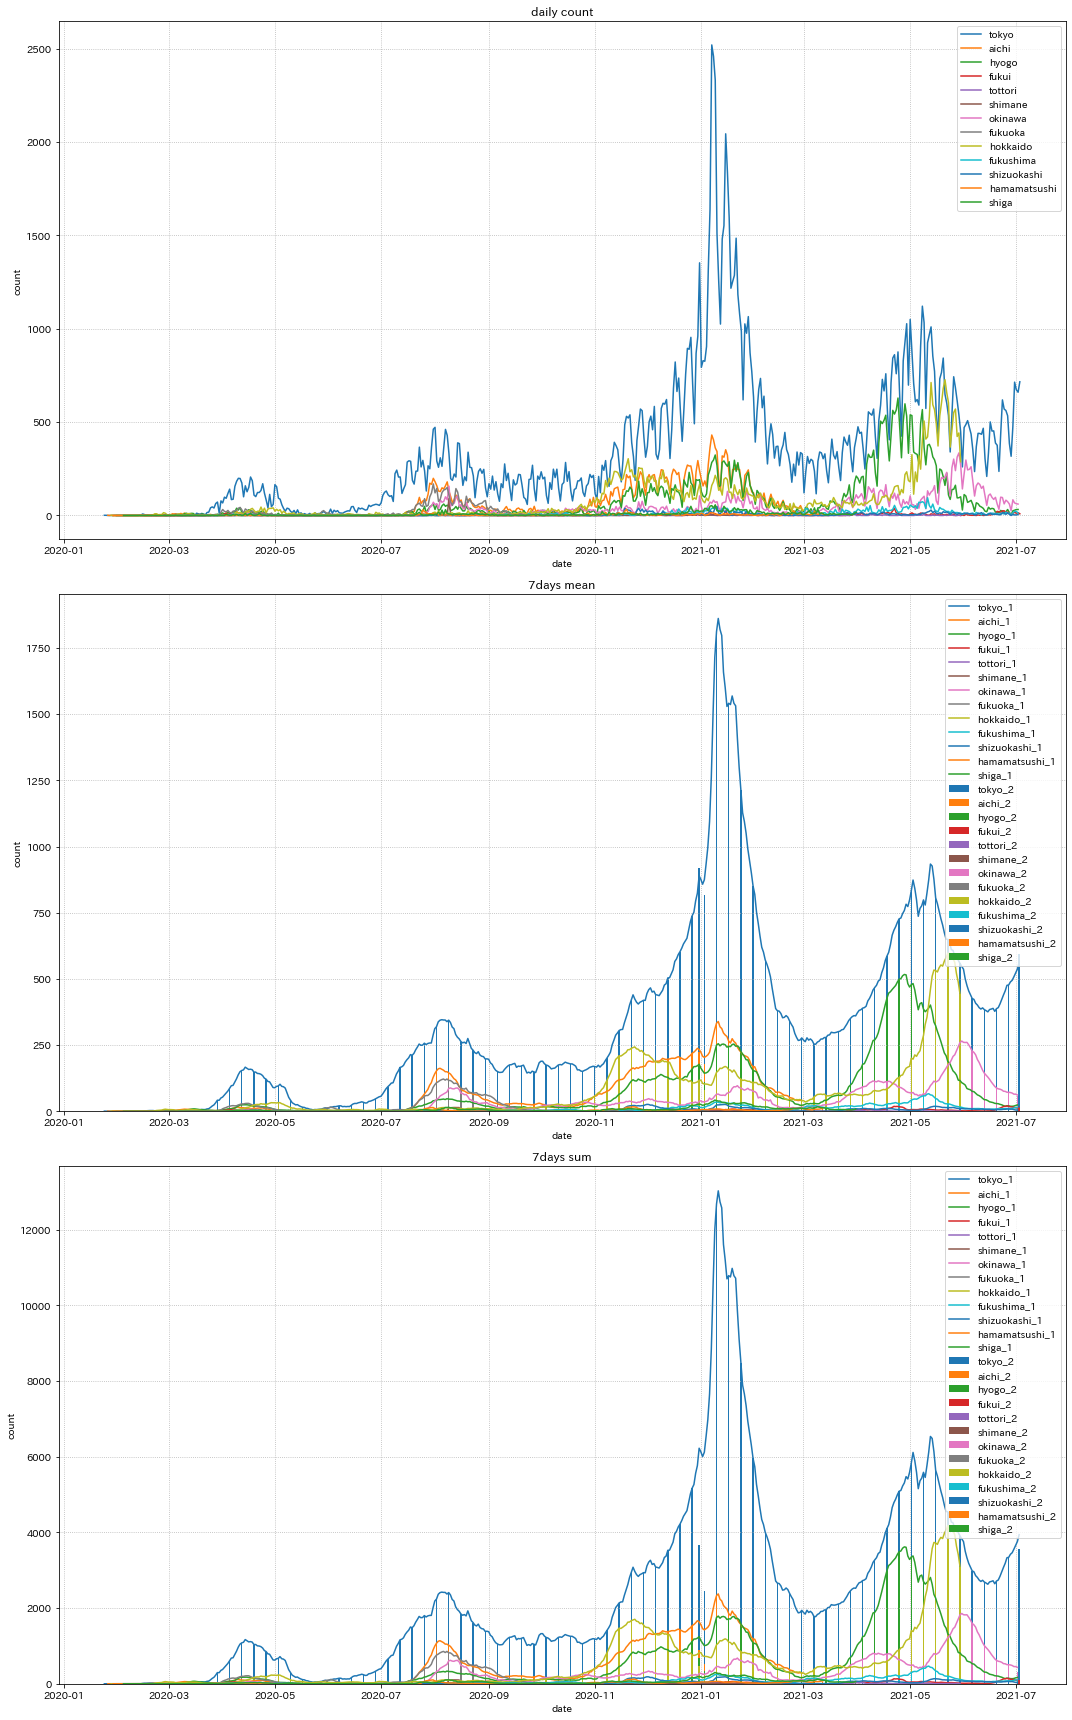

In [30]:
fig, ax = plt.subplots(3, 1, figsize=(15, 24))

for k, v in tqdm(dfs.items()):
    x = v.index
    y1 = v['patients_count']
    ax[0].plot(x, y1, label=k)
    
    y2_1 = v['7d_mov_ave']
    ax[1].plot(x, y2_1, label=f"{k}_1")
    y2_2 = v['week_mean']
    ax[1].bar(x, y2_2, label=f"{k}_2")
    
    y3_1 = v['7d_mov_sum']
    ax[2].plot(x, y3_1, label=f"{k}_1")
    y3_2 = v['week_sum']
    ax[2].bar(x, y3_2, label=f"{k}_2")

for i, _ax in tqdm(enumerate(ax)):
    _ax.set_title(titles[i])
    _ax.set_xlabel('date')
    _ax.set_ylabel('count')
    _ax.grid(linestyle=':')
    _ax.legend()

plt.tight_layout()